# 19.04 Interpreting Estimated Coefficients

The strength of linear regression models lies in their ability to provide straightforward and interpretable solutions that not only predict future outcomes but also provide insight into the underlying processes that create these outcomes.  One of the reasons why linear regression models are so commonplace is that by interpreting estimated coefficients, they can shed light on an underlying relationship.  The process of interpreting the relationship between estimated coefficients and outcomes is called **inference**.

This notebook will explore questions like:
- How much does an increase in an explanatory variable affect the explained variable?
- How can you single out the effect of a specific variable by isolating its effects from those of other variables that also affect the outcome?

The answers to these questions can drive a lot of business value.  Think about a company that likes to measure the performance of its advertising expenditures.  Are radio advertisements more effective in attracting new customers then Facebook ads?  For a thousand dollars spend on TV ads, how many products does the company sell?  And, how can you distinguish whether the new customers are the result of TV ads or Google ads?

Before quantifying the relationship between the individual features and the target variable, you first need to determine whether that feature has a significant role in explaining the target.

The main topics covered in this notebook are: 
- statistical significance
- t-test
- p-value
- inference and the relationship between estimated coefficients and the target
- interpreting continuous and categorical variables
- interpreting interaction terms
- interpreting constants

## Statistical Significance of Individual coefficients

Estimating parameters in a linear regression model does not guarantee that the estimated coefficients are statistically significant.

When estimating a parameter, the ultimate objective is to find its true value in the population.  Often, you need to work with a sample rather than the actual population, and you estimate the coefficients using a sample.  For an individual coefficient to be **statistically significant**, it must have a relatively high value with respect to its standard deviation.  In other words, it must help explain some information in the outcome.

You use **t-tests** to determine if an individual coefficient estimate is statistically different from zero.  This is a way of quantifying a measure of _unique_ variance in the outcome as a function of the parameter, _after controlling for the variance explained by the other parameters_. 

A non-significant parameter does not contribute to the explanation of the information about the outcome variable and can be discarded with little to no decrease in the model's explanatory power.  Moreover, you should treat statistically insignificant coefficients as if they are zero when interpreting the model.  

When you estimate a linear regression model using `statsmodel` the `summary()` function returns t-statistics and associated p-values.  **P-values** are easier to read than t-values.  The p-value associated with a t-test quantifies the likelihood that the estimated coefficient is equal to zero in the real population.  The lower the -pvalue, the more significant the coefficient is.  As a rule of thumb, when the p-value of a coefficient is less than or equal to 0.1, the coefficient is statistically significant.  However, it's admirable to have a p-value that is less than or equal to 0.05.


Use the Medical Costs dataset to illustrate how to interpret the estimated coefficients in a linear regression model.  Load the Medical Costs dataset and build a new regression model including continuous variables as well as the categorical one.  In the dataset there are two continuous variables: age and BMI (body mass index).  In the new model, add them alongside the "is_male" and "is_smoker" dummies as explanatory variables.

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import seaborn as sns
import statsmodels.api as sm 

from sqlalchemy import create_engine 
from sqlalchemy.engine.url import URL 

pd.options.display.float_format = "{:.3f}".format

warnings.filterwarnings(action="ignore")

kagle = dict(
    drivername = "postgresql",
    username = "dsbc_student",
    password = "7*.8G9QH21",
    host = "142.93.121.174",
    port = "5432",
    database = "medicalcosts"
)

In [2]:
# Load the data from the "medicalcosts" database and display some observations

engine=create_engine(URL(**kagle), echo=True)

insurance_df = pd.read_sql_query("SELECT * FROM medicalcosts", con=engine)

engine.dispose()

2019-12-31 10:45:57,185 INFO sqlalchemy.engine.base.Engine select version()
2019-12-31 10:45:57,192 INFO sqlalchemy.engine.base.Engine {}
2019-12-31 10:45:57,290 INFO sqlalchemy.engine.base.Engine select current_schema()
2019-12-31 10:45:57,293 INFO sqlalchemy.engine.base.Engine {}
2019-12-31 10:45:57,394 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-12-31 10:45:57,397 INFO sqlalchemy.engine.base.Engine {}
2019-12-31 10:45:57,447 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-12-31 10:45:57,450 INFO sqlalchemy.engine.base.Engine {}
2019-12-31 10:45:57,500 INFO sqlalchemy.engine.base.Engine show standard_conforming_strings
2019-12-31 10:45:57,502 INFO sqlalchemy.engine.base.Engine {}
2019-12-31 10:45:57,602 INFO sqlalchemy.engine.base.Engine SELECT * FROM medicalcosts
2019-12-31 10:45:57,604 INFO sqlalchemy.engine.base.Engine {}


In [3]:
insurance_df["is_male"] = pd.get_dummies(insurance_df["sex"], drop_first=True)
insurance_df["is_smoker"] = pd.get_dummies(insurance_df["smoker"], drop_first=True)

In [6]:
# Y is the target variable
Y = insurance_df["charges"]

# X is the feature set
X = insurance_df[["is_male", "is_smoker", "age", "bmi"]]

# Add a constant to the model (best practice)
X = sm.add_constant(X)

# Fit an OLS model using statsmodels
results = sm.OLS(Y,X).fit()

# Print the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     986.5
Date:                Tue, 31 Dec 2019   Prob (F-statistic):               0.00
Time:                        10:47:05   Log-Likelihood:                -13557.
No. Observations:                1338   AIC:                         2.712e+04
Df Residuals:                    1333   BIC:                         2.715e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.163e+04    947.267    -12.281      0.0

The estimated model is: 
$$ charges = 116333.50 - 109.04 is\_male + 23833.87 is\_smoker + 259.45 age + 323.05 bmi \qquad(eq. 1) $$
is_male and is_smoker variables are dummies, but the age and BMI variables are continuous.  Interpreting dummies is slightly different than interpreting continuous variables and both will be handled separately.  Before moving forward, you need to understand how to isolate the mutual effects of multiple variables on the target.

## OLS Regression as a Controlled Experiment

A **controlled experiment** is a scientific experiment type where only the effect of a single factor is measured by controlling other factors that also affect teh outcome.  For example, if you wan to measure the effect of linght on the growth of a specific plant, then you need to set up two environments where every factor like humidity, soil, etc. is the same except for the amount of light.

You can think of the estimated linear regression models as a controlled experiment.  When you setimate the coefficients of a model using OLS, you actually get coefficient estimates that are isolated from each other.  That is to say, the coefficient of a feature measures the effect of that variable on the outcome variable by holding all other variables constant at their means.  So you can interpret an estimated coefficient as the measure of the relationship between that feature and the target after stripping out the effects of all other features.

## Interpreting the Dummy variables

Consider the coefficients of the dummy variables in $ (eq.1) $.  The coefficient of is_male is -109.04, and the coefficient of is_smoker is 23833.87.  Moreover, you see that the p-value of is_smoker is very close to zero (0.000), whereas the p-value of is_male is 0.745.  This implies that the coefficient of is_male is effectively zero from a statistical point of view.  It's simply not significant, and you can say that there appears to be no relationship between medical costs and biological sex.

This can be confirmed further by including an additionally variable in the model, the coefficient of is_male can be made statistically significant.  More on that later. 

On the other hand, smoking is a significant factor in the medical costs charged.  According to the estimation, the medical costs of people who smoke are 23,833.87 dollars more than those who do not smoke **on average**.  Recall that when you include dummies in a model, you always hold one group out.  In this example, the holdout group is the non-smokers, and you need to read the coefficient of the is_smoker dummy variable relative to this holdout group.

## Interpreting Continuous Variables 

Now, interpret the coefficients of the continuous variables in (eq.1).  First, both the age and BMI 
variables are statistically significant as the p-values are very close to zero.  The coefficient of age is 259.45.  As a person's age increases by one year, his/her costs increase by 259.45 dollars on average.  Similarly, as BMI increases by one point, medical costs increase by 323.05 dollars on average.

\* Note: Sometimes, transforming the target and the features can lead to a clearer interpretation.  For example, if you take the logarithms of a target and a feature and estimate the model after that, you can interpret the "coefficient" of that feature like this: a percentage increase in the value of the original feature (not log transformed) results in the "coefficient" percentage change in the original target (not log transformed).  Check here for further info: [StackOverflow question](https://stats.stackexchange.com/questions/244199/why-is-it-that-natural-log-changes-are-percentage-changes-what-is-about-logs-th).

## Interpreting the Interaction terms

So far, you've interpreted categorical and continuous variables one at a time.  But sometimes you need to model **interactions** in order to best explain outcomes.  By putting interaction variables in a linear regression model you can capture non-leaner relationships between the target and the features.  For example, from (eq.1), you know the difference of average costs between smokers and non-smokers.  However, if you believe that the costs of smokers would increase as the BMI of a person increases (because the probability of having a heart attack increases) more than the non-smokers, you need to add the interaction of BMI and the is_smoker dummy to the model.

Mathematically, you capture the interaction of two variables by multiplying them.  Now, create an interaction variable and add it to the model.


In [7]:
# Y is the target variable
Y = insurance_df["charges"]

# This is the interaction between bmi and smoking
insurance_df["bmi_is_smoker"] = insurance_df["bmi"] * insurance_df["is_smoker"]

# X is the feature set
X = insurance_df[["is_male", "is_smoker", "age", "bmi", "bmi_is_smoker"]]

# Add a constant to the model (best practice)
X = sm.add_constant(X)

# Fit an OLS model using statsmodel
results = sm.OLS(Y,X).fit()

# Print the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     1365.
Date:                Tue, 31 Dec 2019   Prob (F-statistic):               0.00
Time:                        11:39:07   Log-Likelihood:                -13265.
No. Observations:                1338   AIC:                         2.654e+04
Df Residuals:                    1332   BIC:                         2.657e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -2071.0750    840.644     -2.464

The estimated model is: 
$$ charges = 2017.07 - 473.49 is\_male - 20190 is\_smoker + 244.37age + 7.96 bmi + 1435.60 bmi\_is\_smoker \qquad(eq.2) $$

First, notice that all the coefficients have changed with respect to the previous model.  This is because every time you add or drop a variable, the model specification changes.  This results in different point estimates for the coefficients.  The same is also true for the statistical significance of the coefficients.  For example, the coefficient of the is_male dummy now turns out to be statistically signifigant.

According to the results, a one-point increase in BMI results in 1,435.60 dollar increase for smokers than for non-smokers.  However, you should read this result with caution.  On face, a 1,435.60 dollar increase sounds like a lot for a single-point increase in BMI.  That's probably because the garget variable (charges) is very skewed.  So, linear regression comes up with estimates that measure the relationship on average.

This can be illustrated as follows:


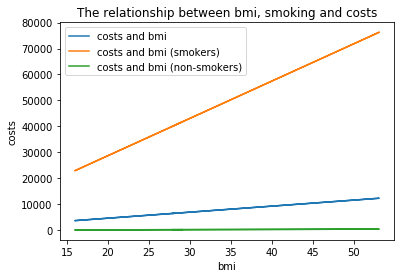

In [8]:
costs_bmi = insurance_df["bmi"] * 232.0511
costs_bmi_smokers = insurance_df["bmi"] * 1435.6081
costs_bmi_non_smokers = insurance_df["bmi"] * 7.9686

plt.plot(insurance_df["bmi"], costs_bmi)
plt.plot(insurance_df["bmi"], costs_bmi_smokers)
plt.plot(insurance_df["bmi"], costs_bmi_non_smokers)

plt.legend(["costs and bmi", "costs and bmi (smokers)", "costs and bmi (non-smokers)"])
plt.xlabel("bmi")
plt.ylabel("costs")
plt.title("The relationship between bmi, smoking and costs")

plt.show();

The <font color=dodgerblue>blue line</font> is the relationship we estimated in (eq.1) between BMI and charges. Since the interaction of BMI and smoking is not included in this model, the estimated value represents an averaged figure for BMI. The <font color=lightgreen>green line</font> is the relationship we estimated in (eq.2) between the charges and BMI for non-smokers, and the <font color=orange>orange line</font> represents the relationship between charges and BMI for smokers. As we see, the increase in charges with an increase in BMI is higher for smokers than non-smokers. Because of the interaction term in (eq.2), we can now distinguish the effects of an increase in BMI on charges between smokers and non-smokers. Notice that the blue line lies between the green and the orange lines as it measures the averaged effect of BMI on charges both for smokers and non-smokers.

## Interpreting the Constant 

Constants in linear regression models correspond to the outcome value that is expected to happen when all the explanatory variables take a zero value.  In a simple linear regression setting (when there is only a single explanatory variable), constants correspond to the point the fitted curve crosses the y-axis.

Although it's easy to visualize the constant term in a simple linear regression setting, it gets harder to grasp what a constant term means if there are many features included in the model.  For example, if a dummy variable is included in a model, then one category should be excluded from the model, as explained before.  In this case the constant term also includes information regarding the holdout category.  Hence, a lot of factors may be captured by the constant.

The safest way to think about the constant term is to think of it as the bias.  Remember that the constant terms make the residuals zero on average.  In this sense, the constant takes the bias from the residuals to itself.  Therefore the constant is also called the bias!